### Abstract

This notebook is intended to do the prediction on the suivavibility of passengers on board on Titanic. 
It is inspired by [a blog post](https://zhuanlan.zhihu.com/p/28739256) from zhihu.com.

In [134]:
import xgboost as xgb

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
# configure notebook to display plots
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,4
rcParams['figure.dpi'] = 300   # the resolution of plotting image
rcParams['savefig.dpi'] = 300

In [41]:
train = pd.read_csv('./titanic_train.csv')
test = pd.read_csv('./titanic_test.csv')
sample_submission = pd.read_csv('./titanic_gender_submission.csv')

print('testing data: ', len(test))
print('training data samples:', len(train))
train.head(20)

testing data:  418
training data samples: 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
#train[train['Survived'] == 1].to_csv('titanic_survived.csv')

In [39]:
sample_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### Feature Engineering

In [53]:

def feature_engineer(titanic, feature_list):
    
    # missing the missing 'age' with median 
    titanic["age"] = titanic["Age"].fillna(titanic["Age"].median())
    
    # add a new feature to indicate whether a passenger is child
    titanic["child"] = titanic["Age"].apply(lambda x: 1 if x < 15 else 0)

    # numeralize the feature 'sex'
    titanic["sex"] = titanic["Sex"].apply(lambda x: 1 if x == "male" else 0)

    # fill the missing data in feature 'Embarked'
    titanic["Embarked"] = titanic["Embarked"].fillna("NA")
    embark_encoder = preprocessing.LabelEncoder()
    titanic["embark"] = embark_encoder.fit_transform(titanic["Embarked"])

    # add a new feature to count the size of family that one belongs to
    titanic["family_size"] = titanic["SibSp"] + titanic["Parch"] + 1

    # fill the missing data for the feature 'cabin'
    def getCabin(cabin):
        if cabin == "N":
            return 0
        else:
            return 1
    titanic["cabin"] = titanic["Cabin"].apply(getCabin)

    # categorize the name based on the marital status
    def getCivil(name):
        if "Mr" in str(name):
            return 1
        elif "Mrs" in str(name):
            return 2
        elif 'Miss' in str(name):
            return 3
        elif 'Dr.' in str(name):
            return 4
        elif 'Master' in str(name):
            return 5
        else:
            return 0
    titanic["civil"] = titanic["Name"].apply(getCivil)

    # fill the missing fare with the median
    titanic["fare"] = titanic["Fare"].fillna(titanic["Fare"].median())

    #return titanic[titanic.columns.difference(
    #    ['Fare', 'Age', 'Name', 'Cabin', 'Embarked', 'Sex', 'SibSb', 'Parch', 'Ticket'])]
    return titanic[feature_list]

In [106]:
feature_list = ['Pclass', 'child', 'fare', 'embark', 'family_size', 'sex']

x_train = feature_engineer(train, feature_list)
x_test  = feature_engineer(test, feature_list)

y_train = train['Survived']

#x_train = df_train[df_train.columns.difference(['Survived', 'PassengerId'])]
#x_test = df_test[df_test.columns.difference(['PassengerId'])]

print('x_train:')
x_train.head(10)

x_train:


,Pclass,child,fare,embark,family_size,sex
0,3,0,7.2500,3,2,1
1,1,0,71.2833,0,2,0
2,3,0,7.9250,3,1,0
3,1,0,53.1000,3,2,0
4,3,0,8.0500,3,1,1
5,3,0,8.4583,2,1,1
6,1,0,51.8625,3,1,1
7,3,1,21.0750,3,5,1
8,3,0,11.1333,3,3,0
9,2,1,30.0708,0,2,0


### XGBoost Model

In [107]:
estimator = XGBClassifier(learning_rate=0.1,
                          max_depth=3,
                          n_estimators = 50,  # number of trees to train
                          silent=False,
                          # binary classification
                          objective='binary:logistic')

estimator.fit(x_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

train accuracy: 0.842873176207


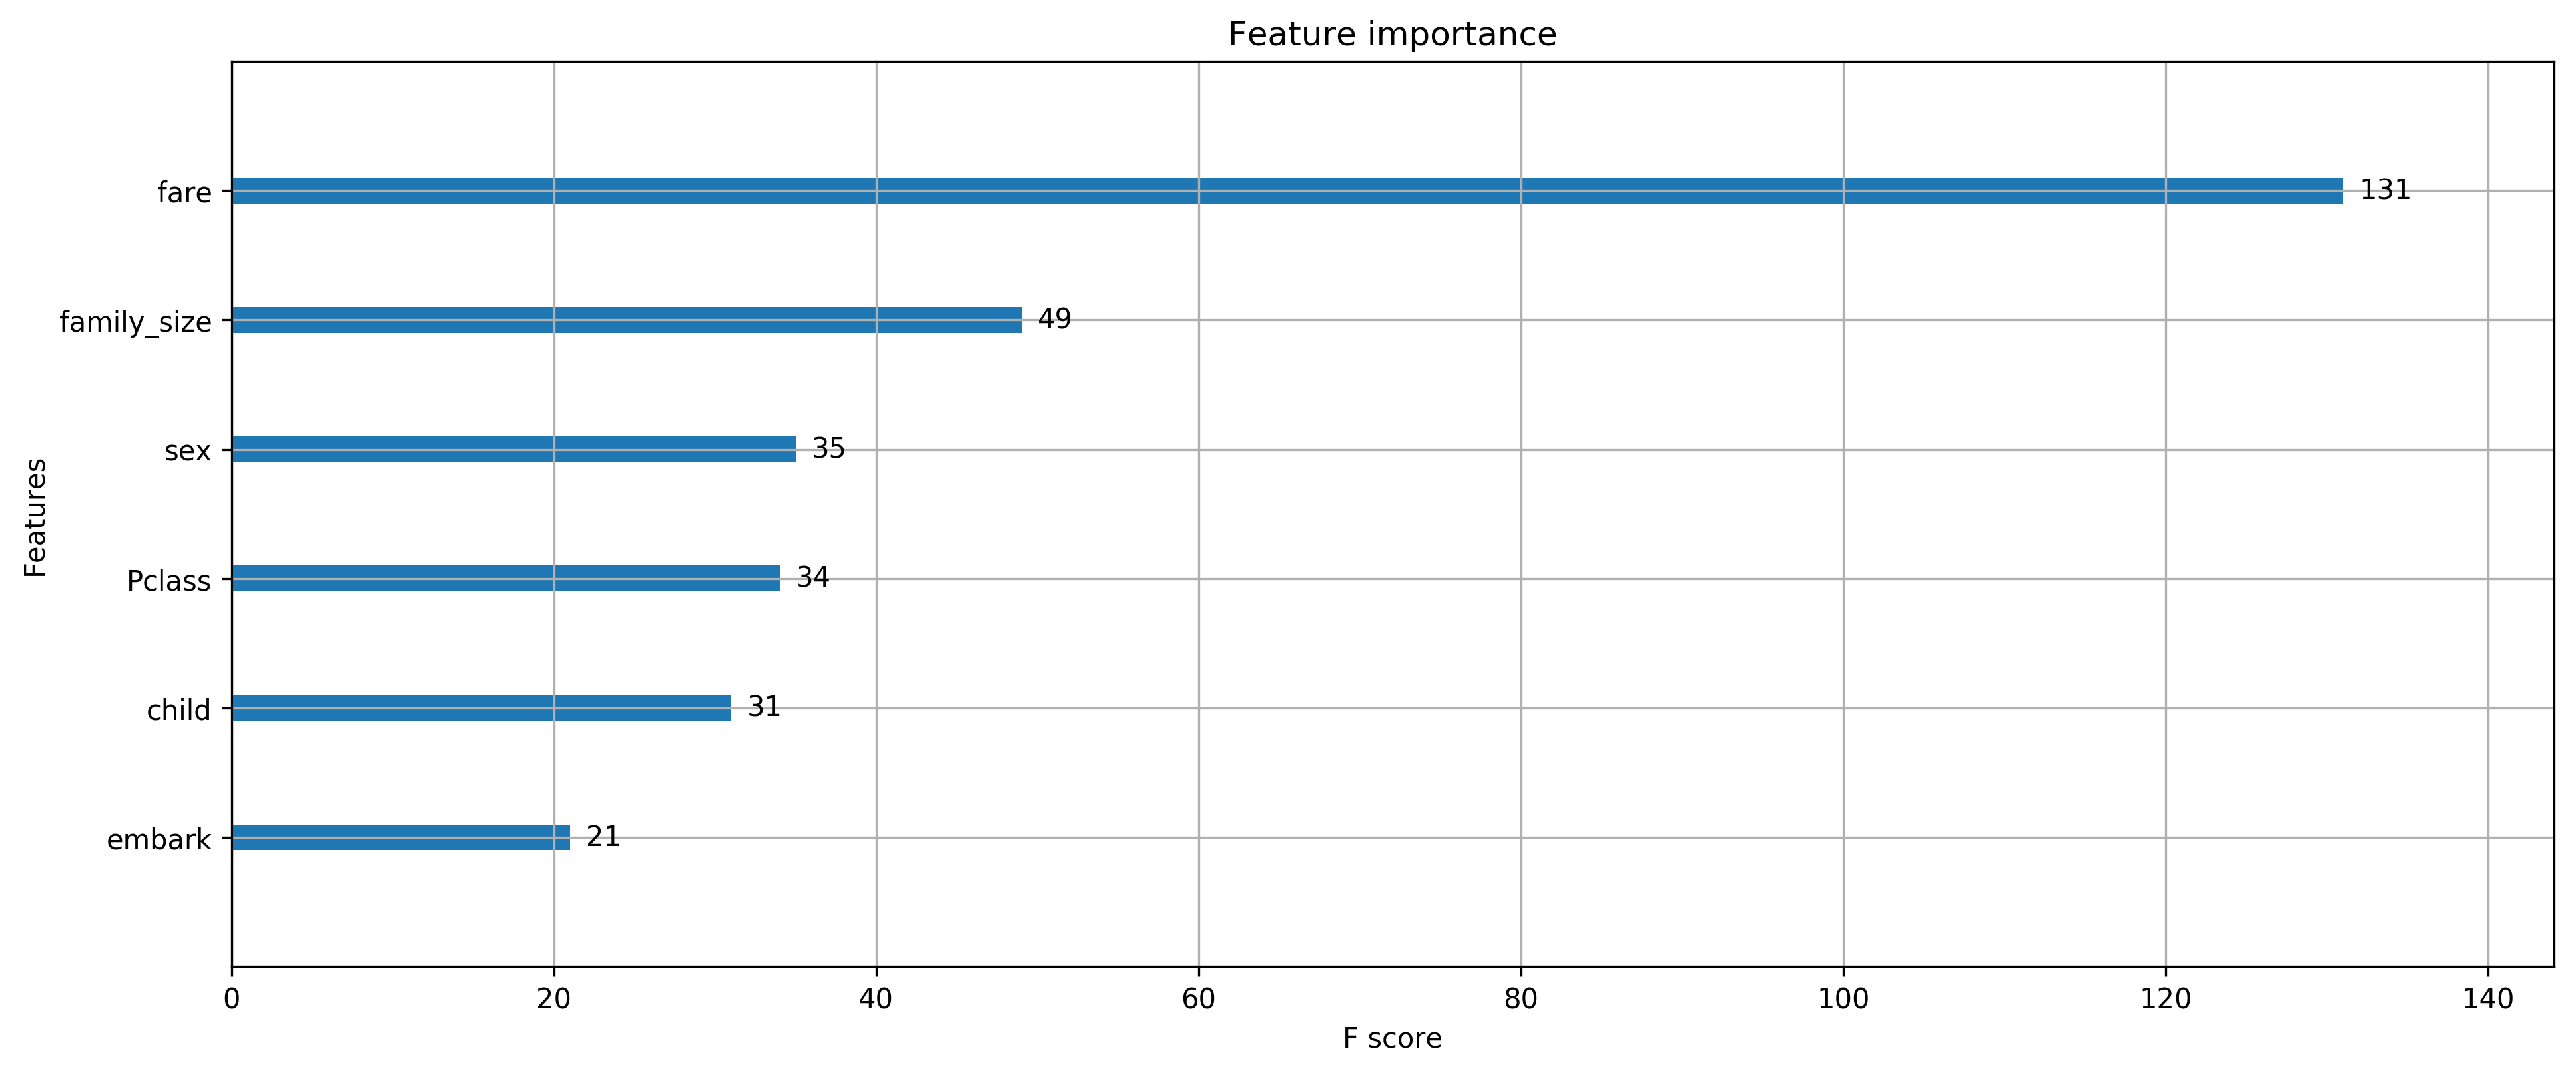

In [132]:
y_train_pred = estimator.predict(x_train)

print('train accuracy:', accuracy_score(y_train, y_train_pred))

_ = xgb.plot_importance(estimator)

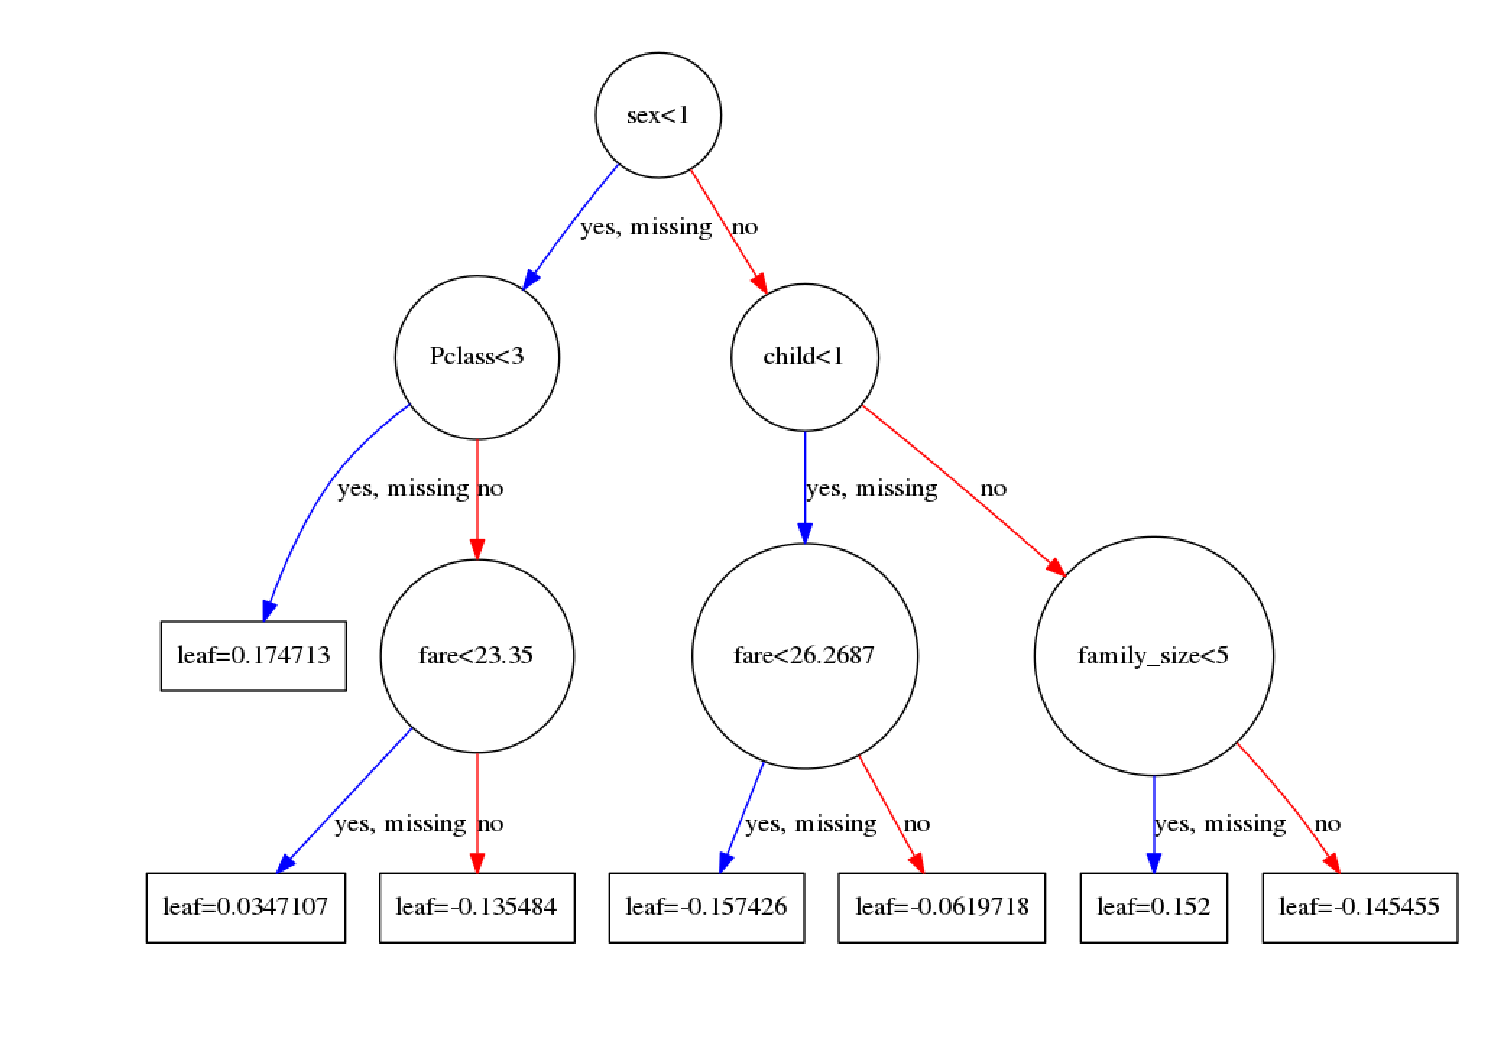

In [136]:
#fig, ax = plt.subplots(figsize=(20, 30))
#fig = plt.figure(figsize=(4,3))

xgb.plot_tree(estimator)

In [61]:
from sklearn.metrics import accuracy_score

def evaluate(estimator, x, y):
    y_pred = estimator.predict(x)
    return accuracy_score(y, y_pred)


def generate_submission(estimator, x_test, IDs):
    y_test_pred = estimator.predict(x_test)

    submission = pd.DataFrame()
    submission['PassengerId'] = IDs
    submission['Survived'] = y_test_pred

    return submission

In [62]:
submission = generate_submission(estimator, x_test, IDs=test['PassengerId'])

submission.head(10)

#submission.to_csv('titanic_submission_350.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


### Evaluation

In [128]:
# cross validation with scikit learn

param_test = {
    'n_estimators': [x for x in range(30, 52, 2)],
    'max_depth':    [x for x in range(2, 6, 1)]
}

grid_search = GridSearchCV(estimator = estimator,
                           param_grid = param_test,
                           scoring='accuracy', 
                           cv=10,
                           verbose=1)

grid_search.fit(x_train, y_train)

print('Best model:', grid_search.best_params_)
print('Best accuracy:', grid_search.best_score_)

Fitting 10 folds for each of 44 candidates, totalling 440 fits
Best model: {'max_depth': 5, 'n_estimators': 30}
Best accuracy: 0.836139169473


[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed:   37.7s finished


In [129]:
submission_2 = generate_submission(grid_search.best_estimator_, x_test, IDs = test['PassengerId'])

print('train accuracy:', evaluate(grid_search.best_estimator_, x_train, y_train))

train accuracy: 0.868686868687


In [130]:
np.where(submission != submission_2)

(array([  5,  28,  34,  36,  37,  39,  87, 104, 138, 169, 177, 199, 225,
        230, 244, 249, 268, 280, 283, 309, 339, 344, 367, 376, 382, 417]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]))

In [131]:
submission_2.to_csv('titanic_submission_530.csv', index=False)